# Exploratory data analysis

In this section we will focus on the raw data. We will try to obtain cleaned train and test data frames with a correct format and no missing values.

Firstly, we will load the files and import the libraries:

In [157]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

In [110]:
# Load train datasets
train_clinical = pd.read_csv("./input/train_clinical_data.csv")
train_proteins = pd.read_csv("./input/train_proteins.csv")
train_peptides = pd.read_csv("./input/train_peptides.csv")
supplemental_clinical = pd.read_csv("./input/supplemental_clinical_data.csv")

# Load test datasets
test_clinical = pd.read_csv("./example_test_files/test.csv")
test_proteins = pd.read_csv("./example_test_files/test_proteins.csv")
test_peptides = pd.read_csv("./example_test_files/test_peptides.csv")

Now we take a look to the data.

In [111]:
train_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [112]:
train_clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB


In [113]:
train_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [114]:
train_peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


We saw that the proteins and peptides tables are not in a readable format, so we need to pivot them in order to merge them to the train clinical table.

In [115]:
# Pivot the proteins and peptides tables so each protein and peptide is a feature
train_proteins = train_proteins.pivot_table(values="NPX", index="visit_id", columns="UniProt")
train_peptides = train_peptides.pivot_table(values="PeptideAbundance", index="visit_id", columns="Peptide")

# Merge the three tables
train = train_clinical.merge(train_proteins, on="visit_id", how="left")  \
                      .merge(train_peptides, on="visit_id", how="left")
                      
# Set the patient id as index
train = train.set_index(["patient_id"])

# Drop the visit id column
train = train.drop("visit_id", axis=1)

We do the same on the test files.

In [116]:
# Pivot the proteins and peptides tables so each protein and peptide is a feature
test_proteins = test_proteins.pivot_table(values="NPX", index="patient_id", columns="UniProt")
test_peptides = test_peptides.pivot_table(values="PeptideAbundance", index="patient_id", columns="Peptide")

# Set the patient id as index
test_clinical = test_clinical.set_index(["patient_id"])

# Merge the three tables
test = test_proteins.merge(test_peptides, on="patient_id", how="left")

In [117]:
train.head()

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,39585.8,41526.9,...,201158.0,16492.3,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,35220.8,41295.0,...,171079.0,13198.8,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
55,9,8.0,9.0,30.0,0.0,On,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,41650.9,39763.3,...,231772.0,17873.8,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1


In [118]:
test.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15031,O15240,O15394,O43505,...,YSSDYFQAPSDYR,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
patient_id,,,,,,,,,,,,,,,,,,,,,
3342,14564.0,616804.0,61418.1,27830.1,14959.2,2853.12,NaN,223373.0,58863.0,207497.0,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
50423,33127.9,490742.0,43615.3,NaN,16486.6,2882.42,11963.7,124344.0,57688.1,200364.0,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23


In order to create a useful model, we have to use the features that are available in both, the train and test files. That is why we will know update the train and test data frames with just the common columns.

In [119]:
# Create a list of common columns
train_cols = train.columns.values[5:]
test_cols = test.columns.values
cols = list(set(train_cols) & set(test_cols))

# Use only common columns
train = train[list(train.columns.values[:5]) + cols]
test = test[cols]

Now we have to deal with the missing values. Firstly we print the na information for the train dataset.

In [120]:
print(train.isna().sum().sort_values(ascending=False))

TPSGLYLGTC(UniMod_4)ER    2046
HYEGSTVPEK                2032
VAPDEHPILLTEAPLNPK        2023
Q562R1                    2023
LTASAPGYLAITK             2020
                          ... 
updrs_4                   1038
updrs_3                     25
updrs_2                      2
updrs_1                      1
visit_month                  0
Length: 1171, dtype: int64


Every column has a huge amount of missing values so we can't remove the rows that are not completed. We will take the following strategy:

- For the missing values in the symptoms columns, we will assume that the patient had no symptom and will set them to 0.
- For patients that have some missing values but not all of them in each protein and peptides, we will interpolate the missing values.
- For proteins and peptides that have no value in a patient, we will fill them with the mean.

In [121]:
# Define a list with symptoms
updrs_cols = ['updrs_1','updrs_2','updrs_3','updrs_4']

# Fill updrs and state of medication values
for updrs in updrs_cols:
    train[updrs] = train[updrs].fillna(0).round()

# Create a list of the ids of the patients
patient_id = list(train.index.unique())

# Interpolate the missing data of every patient
for patient in patient_id:
    train.loc[patient] = train.loc[patient].interpolate(method="linear").fillna(method="bfill")
    
# Fill the remaining na values with the mean of the columns
train = train.fillna(train.mean())

Now we check again the missing values:

In [122]:
print(train.isna().sum().sum())

0


In [123]:
# Create a list of the ids of the patients
patient_id_test = list(test.index.unique())

# Interpolate the missing data of every patient
for patient in patient_id_test:
    test.loc[patient] = test.loc[patient].interpolate(method="linear").fillna(method="bfill")

# Fill the remaining na values with the mean of the columns
test = test.fillna(test.mean())

Once we have filled the data frame, we need to normalize the data. We normalize the input values from both, the training and testing tables. We have decided to choose a normalization between 0 and 1.

In [124]:
# Normalize all the columns values from the train and the test dataset
for col in cols:
    values_list = np.array(list(train[col]) + list(test[col]))
    train[col] = (train[col] - values_list.min()) / (values_list.max() - values_list.min())
    test[col] = (test[col] - values_list.min()) / (values_list.max() - values_list.min())

# Model selection

Due to we have to predict both, the actual symptom level and its progression, we will do the following:

- Firstly we will create a linear regression to predict the slope of the symptom progression 
- Then we will try various models to predict every symptom and its slope based on proteins and peptide levels
- We then compare the models and pick the best one
- Finally we do hyperparameter tuning and improve the models

Lets start with the linear regression:

First we can plot the linear regression of a random patient.

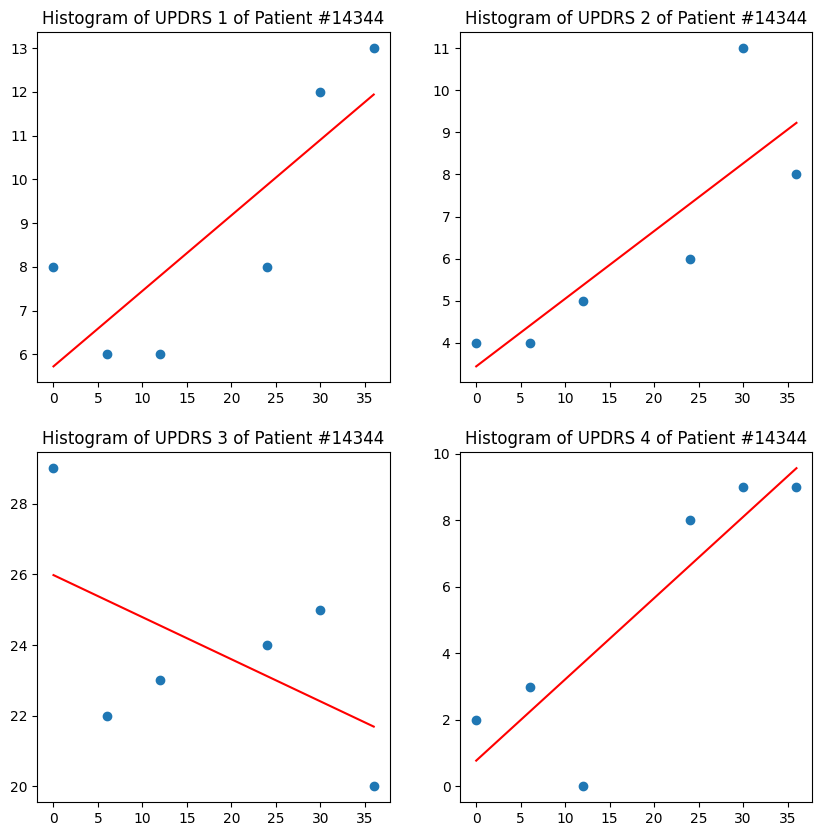

In [125]:
# Estimating updrs of one patient based on month_visit
linear_regressors_list = []
fig, axs = plt.subplots(2, 2,figsize=(10,10))
aux = 0
patient = random.choice(patient_id)

for idx, updrs in enumerate(updrs_cols):
    np_x = train.loc[patient]['visit_month'].values.reshape(-1, 1)
    np_y = train.loc[patient][updrs].values.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(np_x, np_y)
    if(aux == 2):
        aux = 0
    axs[idx//2, aux].scatter(np_x,  np_y)
    axs[idx//2, aux].plot(np_x, lr.predict(np_x), color='red')
    axs[idx//2, aux].set_title(f'Histogram of UPDRS {idx + 1} of Patient #{patient}')
    aux += 1

We can see how the progression of the disease is more or less linear. Now we will create a linear regression for every patient and store the slope in a new dictionary.

In [126]:
# Empty dict for slopes
updrs_slopes = {}
r_squared = {}
mae = {}

# Create an empty list to store the metric for each patient
for updrs in updrs_cols:
    r_squared[updrs] = []
    mae[updrs] = []

# Slope and intercept for every patient and updrs
for patient in patient_id:
    
    # Create empty dicts of lists
    updrs_slopes[patient] = []
    
    for updrs in updrs_cols:
        
        X = train.loc[patient]['visit_month'].values.reshape(-1, 1)
        y = train.loc[patient][updrs].values.reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(X, y)
        updrs_slopes[patient].append(float(lr.coef_))
        r_squared[updrs].append(r2_score(y, lr.predict(X)))
        mae[updrs].append(mean_absolute_error(y, lr.predict(X)))

# Create df for slopes
slopes_df = pd.DataFrame.from_dict(updrs_slopes, orient="index", columns=[s + "_slope" for s in updrs_cols])

# Merge all the data in the train data frame
train = train.merge(slopes_df, how="left", left_index=True, right_index=True)

Now we can check the R2 value and the mean absolute error of every symptom.

In [127]:
for updrs in updrs_cols:
    print(f"R^2 mean of UPDRS {updrs} regression: {np.array(r_squared[updrs]).mean().round(2)}")
    print(f"MAE mean of UPDRS {updrs} regression: {np.array(mae[updrs]).mean().round(2)}")

R^2 mean of UPDRS updrs_1 regression: 0.28
MAPE mean of UPDRS updrs_1 regression: 1.61
R^2 mean of UPDRS updrs_2 regression: 0.42
MAPE mean of UPDRS updrs_2 regression: 1.29
R^2 mean of UPDRS updrs_3 regression: 0.31
MAPE mean of UPDRS updrs_3 regression: 3.44
R^2 mean of UPDRS updrs_4 regression: 0.67
MAPE mean of UPDRS updrs_4 regression: 0.6


We can see how the metrics are not bad. Now we will try to predict the actual updrs levels and slopes based on the proteins and peptides.

Firstly we, are defining the metric we want to use. We will use the symmetric mean absolute percentage error (SMAPE). We define the metric in the following cell:

In [171]:
# Define the smape metric
def smape(true, pred):
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred)))

# We create a scorer object
smape_scorer = make_scorer(smape, greater_is_better=False)

Now we are going to try an extreme gradient boost model. We will perform cross validation and print the results.

In [172]:
X = train.iloc[:, 5:-4]
y = train["updrs_1"]

kf = KFold(n_splits=3, shuffle=True, random_state=42)
xgb = XGBRegressor(objective="reg:smape")
cv_results = cross_val_score(xgb, X, y, cv=kf, scoring=smape_scorer)


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/carlos/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1025, in fit
    self._Booster = train(
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [22:40:18] ../src/objective/objective.cc:26: Unknown objective function: `reg:smape`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: rank:pairwise
Objective candidate: rank:ndcg
Objective candidate: rank:map
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror

Stack trace:
  [bt] (0) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x3708b3) [0x7f2ac8d708b3]
  [bt] (1) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x370f8f) [0x7f2ac8d70f8f]
  [bt] (2) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2e543c) [0x7f2ac8ce543c]
  [bt] (3) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2ebfd7) [0x7f2ac8cebfd7]
  [bt] (4) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2e02f8) [0x7f2ac8ce02f8]
  [bt] (5) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f2ac8b3c5f0]
  [bt] (6) /home/carlos/miniconda3/lib/python3.10/lib-dynload/../../libffi.so.8(+0xa052) [0x7f2b1b948052]
  [bt] (7) /home/carlos/miniconda3/lib/python3.10/lib-dynload/../../libffi.so.8(+0x88cd) [0x7f2b1b9468cd]
  [bt] (8) /home/carlos/miniconda3/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x91e7) [0x7f2b1b9581e7]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/carlos/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1025, in fit
    self._Booster = train(
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [22:40:19] ../src/objective/objective.cc:26: Unknown objective function: `reg:smape`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: rank:pairwise
Objective candidate: rank:ndcg
Objective candidate: rank:map
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror

Stack trace:
  [bt] (0) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x3708b3) [0x7f2ac8d708b3]
  [bt] (1) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x370f8f) [0x7f2ac8d70f8f]
  [bt] (2) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2e543c) [0x7f2ac8ce543c]
  [bt] (3) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2ebfd7) [0x7f2ac8cebfd7]
  [bt] (4) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2e02f8) [0x7f2ac8ce02f8]
  [bt] (5) /home/carlos/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f2ac8b3c5f0]
  [bt] (6) /home/carlos/miniconda3/lib/python3.10/lib-dynload/../../libffi.so.8(+0xa052) [0x7f2b1b948052]
  [bt] (7) /home/carlos/miniconda3/lib/python3.10/lib-dynload/../../libffi.so.8(+0x88cd) [0x7f2b1b9468cd]
  [bt] (8) /home/carlos/miniconda3/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x91e7) [0x7f2b1b9581e7]




In [170]:
print(cv_results)

[-inf -inf -inf]


In [141]:
# Create dictionaries to store the models
updrs_predictors = {}

# Define X
X = train.iloc[:, 5:-4]

# Train a model per each symptom
for updrs in updrs_cols:
    
    X_train, X_test, y_train, y_test = train_test_split(X, train[updrs], test_size=0.2, random_state=42)

    updrs_predictors[updrs] = XGBRegressor().fit(X_train, y_train)
    
    print(f"MAE for {updrs}: {mean_absolute_error(y_test, updrs_predictors[updrs].predict(X_test))}")

MAE for updrs_1: 2.549745653145172
MAE for updrs_2: 2.527688320475073
MAE for updrs_3: 6.599318220461745
MAE for updrs_4: 1.0720909029511596


In [130]:
# Create dictionaries to store the slope models
updrs_slopes_predictors = {}

# Define X
X = train.iloc[:, 5:-4]

# Train a model per each symptom
for updrs in updrs_cols:
    
    X_train, X_test, y_train, y_test = train_test_split(X, train[updrs + "_slope"], test_size=0.2, random_state=42)

    updrs_slopes_predictors[updrs] = XGBRegressor().fit(X_train, y_train)
    
    print(f"MAE for {updrs} slope: {mean_absolute_error(y_test, updrs_slopes_predictors[updrs].predict(X_test))}")

MAE for updrs_1 slope: 0.014705526159299518
MAE for updrs_2 slope: 0.015137603623584663
MAE for updrs_3 slope: 0.03924831400905548
MAE for updrs_4 slope: 0.008544546455159844


In [129]:
train.updrs_1_slope.mean()

0.043538472738761554

In [142]:
# Load sample submission fie
output_doc = pd.read_csv("./example_test_files/sample_submission.csv")
output_doc = output_doc.drop(index=output_doc.index)

for idx, patient in enumerate(patient_id_test):
    
    visit_id  = test_clinical.loc[patient].visit_id.values[idx+3]   # In order to match group_id of patient 50423 
    group_key = test_clinical.loc[patient].group_key.values[idx+3] # In order to match group_id of patient 50423 

    for updrs in updrs_cols:
        
        # Updrs values predicted with protein and peptides
        updrs_prediction = updrs_predictors[updrs].predict(test.loc[patient].values.reshape(1,-1))
        
        prediction_id = f'{visit_id}_{updrs}_plus_0_months'
        new_row = {'prediction_id': prediction_id, 'rating': int(updrs_prediction.round()), 'group_key': group_key}
        output_doc = output_doc.append(new_row, ignore_index=True)
        
        # To get the slope
        slope = updrs_slopes_predictors[updrs].predict(test.loc[patient].values.reshape(1,-1))
                
        for month in range(6, 25, 6):
            
            #Compute the evolution at a given month
            updrs_prediction =  (updrs_prediction + slope * month)
            prediction_id = f'{visit_id}_{updrs}_plus_{month}_months'
            new_row = {'prediction_id': prediction_id, 'rating': int(updrs_prediction.round()), 'group_key': group_key}
            output_doc = output_doc.append(new_row, ignore_index=True)

output_doc.to_csv('submission.csv',  index = False)

/tmp/ipykernel_4828/1295681615.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_doc = output_doc.append(new_row, ignore_index=True)
/tmp/ipykernel_4828/1295681615.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_doc = output_doc.append(new_row, ignore_index=True)
/tmp/ipykernel_4828/1295681615.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_doc = output_doc.append(new_row, ignore_index=True)
/tmp/ipykernel_4828/1295681615.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_doc = output_doc.append(new_row, ignore_index=True)
/tmp/ipykernel_4828/1295681615.py:28: FutureWarning: The frame.append me